In [17]:
%pylab inline
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import astropy.io.ascii as ascii
import cosmology
cosmo=cosmology.Cosmo(h=1.,omega_m=0.315)
from scipy.interpolate import griddata
if False:
    detfname='/work/xiangchong.li/work/massMapSparse/sim/planck-cosmo/nfw-halos/haloDet-NFW-lbd50-nu15.csv'
    figMsDir='/work/xiangchong.li/superonionGW/code/massMap_Private/doc/paper_ms_method_HSCY1/'
else:
    detfname='/home/xiangchong/work/gw_ipmu/work/massMapSparse/sim/planck-cosmo/nfw-halos/haloDet-NFW-lbd50-nu15.csv'
    figMsDir='/home/xiangchong/.local/code/massMap_Private/doc/paper_ms_method_HSCY1/'
data=ascii.read(detfname)

Populating the interactive namespace from numpy and matplotlib


In [2]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=13.5,Mmax=15.2,dlog10m=0.1,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


In [3]:
nsamp=25
zbound=np.linspace(0.01,0.85,nsamp+1)
zmin=zbound[:-1]
zmax=zbound[1:]
zave=(zmin+zmax)/2.

zlist=[]
mlist=[]
nlist=[]
for iz in range(nsamp):
    z=zave[iz]
    mf.update(z=z)
    v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
    print(v)
    mass_func = mf.dndlog10m
    logm = np.log10(mf.m)
    nm=len(logm)
    for i in range(nm):
        zlist.append(z)
        mlist.append(logm[i])
        nlist.append(mass_func[i]*v)
zlist=np.array(zlist)
mlist=np.array(mlist)
nlist=np.array(nlist)*mf.dlog10m

217.04777386725726
970.4916415366243
2241.481025656045
3973.3846629393825
6111.566617508843
8603.79722664213
11400.578224336152
14455.384875088896
17724.83034791013
21168.75930410528
24750.27880106814
28435.735197393806
32194.645868943946
35999.59430492065
39826.09664006644
43652.44697906175
47459.54805632219
51230.732910244784
54951.582383932626
58609.74243058874
62194.74442609835
65697.83098951419
69111.78919231388
72430.79250173371
75650.25235026918


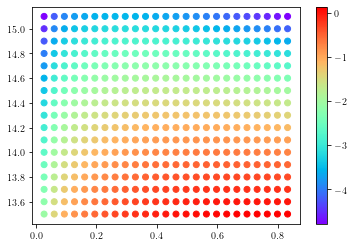

In [4]:
plt.scatter(zlist,mlist,c=np.log10(nlist),cmap='rainbow')
plt.colorbar()

In [5]:
print(np.sum(nlist))

72.4693516845021


In [6]:
mask=mlist<13.9
print(nlist[mask])

[0.00871066 0.00683911 0.00532621 0.00410998 0.00313436 0.0382319
 0.02993159 0.02323501 0.0178638  0.01356695 0.08659426 0.0675922
 0.05229319 0.04005168 0.03028693 0.15038244 0.11701877 0.09021545
 0.06882323 0.05181097 0.22636884 0.17557906 0.13487005 0.10246648
 0.07677963 0.31153775 0.24083013 0.18429398 0.13941919 0.10396547
 0.40310461 0.31053315 0.23670395 0.17827672 0.1322781  0.49852986
 0.38266351 0.29050338 0.21779613 0.16076601 0.59552794 0.45541686
 0.34428565 0.25689737 0.18861583 0.69207061 0.52720995 0.39683312
 0.29466058 0.21514848 0.78638678 0.59667879 0.44711379 0.33032161
 0.23981381 0.87695736 0.66267246 0.4942743  0.36326456 0.26218276
 0.9625075  0.72424476 0.53763128 0.39301287 0.2819387  1.04199457
 0.78064246 0.57665984 0.41921836 0.29886689 1.11459535 0.83129285
 0.61098178 0.44164998 0.31284419 1.17969029 0.87578915 0.64035193
 0.46018144 0.32382776 1.23684699 0.91387523 0.66464433 0.47477861
 0.33184402 1.28580267 0.94542981 0.68383803 0.48548706 0.336977

In [7]:
zdet=data['zh']
log10mDet=data['log10_M200']
det=data['detRat']

In [8]:
def grid_interpolate_2d(x, y, z, eval_x, eval_y):
    """
    This is a utility for interpolating a 2D function z(x, y) linearly to values
    (x, y) = (eval_x, eval_y), but also enabling extrapolation beyond the (x, y)
    bounds using the nearest neighbor method.
    """
    result = griddata((x, y), z, (eval_x, eval_y), method='linear')
    nn_result = griddata((x, y), z, (eval_x, eval_y), method='nearest')
    mask = np.isnan(result)
    result[mask] = nn_result[mask]
    return result

detEst=grid_interpolate_2d(zdet,log10mDet,det, zlist, mlist)

/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


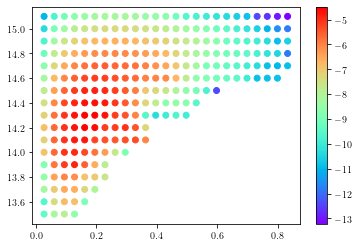

In [9]:
plt.scatter(zlist,mlist,c=log(nlist*detEst),cmap='rainbow')
plt.colorbar()

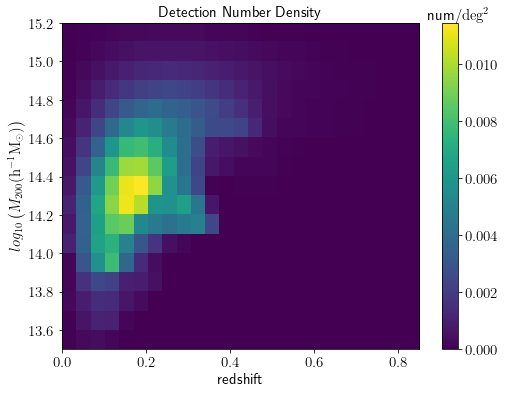

In [26]:
sp=(len(zave),len(zlist)//len(zave))
plt.figure(figsize=(8,6))
plt.title('Detection Number Density',fontsize=15)
plt.imshow(np.transpose((nlist*detEst).reshape(sp)),aspect='auto',origin='lower',extent=(0,0.85,13.5,15.2))
plt.xlabel('redshift',fontsize=15)
plt.ylabel(r'$log_{10}\left(M_{200} (\rm{h^{-1}M_{\odot}})\right)$',fontsize=15)
clb=plt.colorbar()
clb.set_label(r'num$/\rm{deg}^2$', labelpad=-40, y=1.05, rotation=0)
plt.savefig(os.path.join(figMsDir,'detNum_zm.pdf'))

In [21]:
np.sum(nlist*detEst)

0.4902572669444762

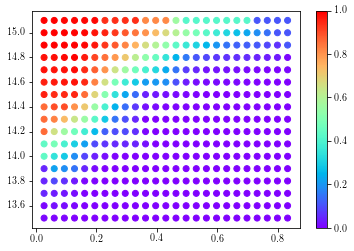

In [304]:
plt.scatter(zlist,mlist,c=detEst,cmap='rainbow')
plt.colorbar()